In [ ]:
from pathlib import Path
import torch
import torch.nn as nn
from config import get_config, get_weights_file_path
from train import get_model, get_ds, run_validation, causal_mask
import os

In [ ]:
from get_accuracy import *
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
def beam_search_decode(model, beam_size, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Precompute the encoder output and reuse it for every step
    encoder_output = model.encode(source, source_mask)
    # Initialize the decoder input with the sos token
    decoder_initial_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)

    # Create a candidate list
    candidates = [(decoder_initial_input, 1)]

    while True:

        # If a candidate has reached the maximum length, it means we have run the decoding for at least max_len iterations, so stop the search
        if any([cand.size(1) == max_len for cand, _ in candidates]):
            break

        # Create a new list of candidates
        new_candidates = []

        for candidate, score in candidates:

            # Do not expand candidates that have reached the eos token
            if candidate[0][-1].item() == eos_idx:
                continue

            # Build the candidate's mask
            candidate_mask = causal_mask(candidate.size(1)).type_as(source_mask).to(device)
            # calculate output
            out = model.decode(encoder_output, source_mask, candidate, candidate_mask)
            # get next token probabilities
            prob = model.project(out[:, -1])
            # get the top k candidates
            topk_prob, topk_idx = torch.topk(prob, beam_size, dim=1)
            for i in range(beam_size):
                # for each of the top k candidates, get the token and its probability
                token = topk_idx[0][i].unsqueeze(0).unsqueeze(0)
                token_prob = topk_prob[0][i].item()
                # create a new candidate by appending the token to the current candidate
                new_candidate = torch.cat([candidate, token], dim=1)
                # We sum the log probabilities because the probabilities are in log space
                new_candidates.append((new_candidate, score + token_prob))

        # Sort the new candidates by their score
        candidates = sorted(new_candidates, key=lambda x: x[1], reverse=True)
        # Keep only the top k candidates
        candidates = candidates[:beam_size]

        # If all the candidates have reached the eos token, stop
        if all([cand[0][-1].item() == eos_idx for cand, _ in candidates]):
            break

    # Return the best candidate
    return candidates[0][0].squeeze()

def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Precompute the encoder output and reuse it for every step
    encoder_output = model.encode(source, source_mask)
    # Initialize the decoder input with the sos token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)
    while True:
        if decoder_input.size(1) == max_len:
            break

        # build mask for target
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # calculate output
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # get next token
        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1
        )

        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0)

def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, num_examples=2, plot=False, print_text=False):
    model.eval()
    count = 0
    cc_init = []
    cc_beam = []
    cc_greedy = []

    try:
        # get the console window width
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        # If we can't get the console width, use 80 as default
        console_width = 80

    with torch.no_grad():
        for batch in tqdm(validation_ds):
            count += 1
            encoder_input = batch["encoder_input"].to(device) # (b, seq_len)
            encoder_mask = batch["encoder_mask"].to(device) # (b, 1, 1, seq_len)

            # check that the batch size is 1
            assert encoder_input.size(
                0) == 1, "Batch size must be 1 for validation"

            
            model_out_greedy = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)
            model_out_beam = beam_search_decode(model, 3, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]
            model_out_text_beam = tokenizer_tgt.decode(model_out_beam.detach().cpu().numpy())
            model_out_text_greedy = tokenizer_tgt.decode(model_out_greedy.detach().cpu().numpy())
            

            # get accuracy
            c_greedy, _, _ = get_accuracy2(target_text, model_out_text_greedy, source_text, plot=plot)
            cc_greedy.append(c_greedy)
            c_beam, _, _ = get_accuracy2(target_text, model_out_text_beam, source_text, plot=plot)
            cc_beam.append(c_beam)
            
            # Print the source, target and model output
            if print_text:
                print_msg('-'*console_width)
                print_msg(f"{f'SOURCE: ':>20}{source_text}")
                print_msg(f"{f'TARGET: ':>20}{target_text}")
                print_msg(f"{f'PREDICTED GREEDY: ':>20}{model_out_text_greedy}")
                print_msg(f"{f'PREDICTED BEAM: ':>20}{model_out_text_beam}")
                print_msg(f"{f'CC greedy: ':>12}{c_greedy:.3f}")
                print_msg(f"{f'CC beam: ':>12}{c_beam:.3f}")

            
            if count == num_examples:
                print_msg('-'*console_width)
                plt.figure()
                sns.violinplot(data=[cc_greedy,cc_beam])
                plt.xticks(ticks = [0, 1], labels = ['greedy', 'beam'], fontsize = 11)
                plt.show()
                plt.close()
                
                plt.figure()
                x = cc_beam
                y = cc_greedy
                plt.scatter(x, y)
                plt.xlabel('beam search')
                plt.ylabel('greedy prediction')
                x = np.linspace(min(x), max(y), 100)
                plt.plot(x,x, '-r', label='y=x')
                plt.show()
                plt.close()
                
                break


In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
config = get_config()
train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

# Load the pretrained weights
model_filename = get_weights_file_path(config, f"19")
state = torch.load(model_filename)
model.load_state_dict(state['model_state_dict'])

  2%|▏         | 199/10000 [05:08<4:09:41,  1.53s/it]

--------------------------------------------------------------------------------


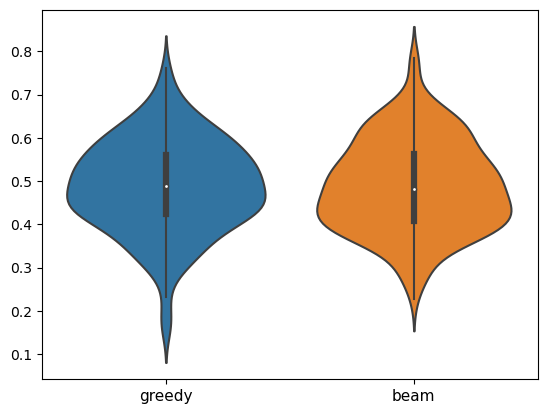

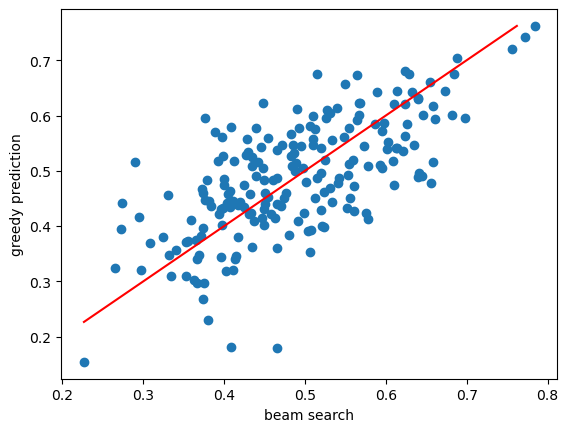

  2%|▏         | 199/10000 [05:09<4:14:25,  1.56s/it]


In [5]:
plot=False
print_text=False
run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, print_msg=print, num_examples=200, plot=plot, print_text=print_text)

stty: 'standard input': Inappropriate ioctl for device
  0%|          | 0/10000 [00:00<?, ?it/s]

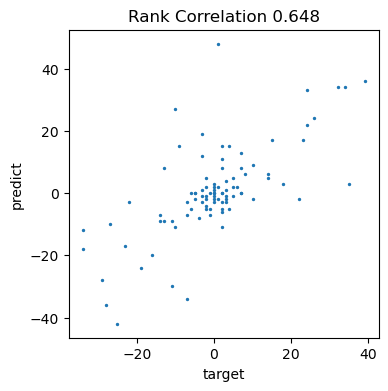

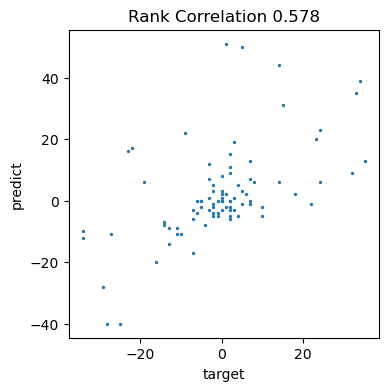

  0%|          | 1/10000 [00:01<4:43:26,  1.70s/it]

--------------------------------------------------------------------------------
            SOURCE: G87 G81 G26 G90 G15 G37 G6 G71 G73 G19 G2 G9 G52 G84 G72 G11 G78 G29 G30 G82 G36 G25 G60 G1 G33 G56 G51 G97 G67 G66 G91 G22 G100 G55 G77 G4 G65 G61 G59 G62 G57 G94 G68 G27 G70 G83 G58 G3 G89 G21 G74 G64 G44 G98 G47 G12 G63 G38 G35 G14 G69 G95 G34 G45 G13 G86 G92 G42 G39 G79 G49 G85 G31 G10 G17 G46 G96 G43 G23 G80 G53 G93 G18 G41 G54 G24 G16 G75 G8 G99 G7 G40 G5 G20 G50 G32 G88 G48 G76 G28
            TARGET: G87 G90 G26 G6 G81 G2 G73 G37 G11 G71 G9 G15 G52 G97 G78 G19 G84 G22 G29 G33 G51 G72 G56 G30 G60 G25 G82 G100 G67 G55 G1 G66 G91 G4 G36 G61 G77 G65 G62 G94 G59 G44 G57 G58 G27 G64 G63 G68 G12 G21 G92 G17 G3 G75 G70 G13 G89 G54 G39 G83 G18 G32 G85 G7 G86 G74 G24 G53 G88 G76 G79 G98 G48 G10 G5 G23 G96 G42 G40 G14 G43 G38 G80 G50 G93 G8 G34 G41 G47 G16 G35 G99 G28 G20 G95 G31 G49 G46 G45 G69
  PREDICTED GREEDY: G87 G90 G81 G6 G26 G37 G9 G71 G2 G52 G84 G19 G11 G73 G72 G29 G25 G15 G78 G8

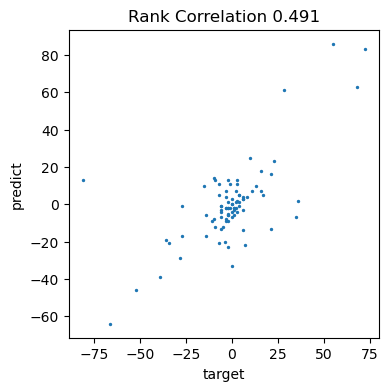

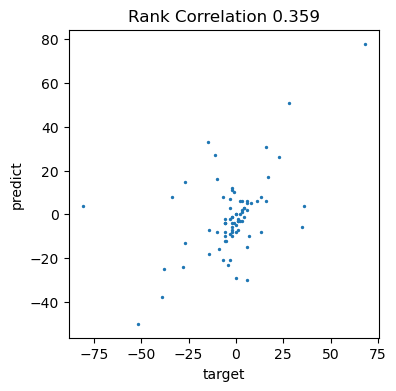

  0%|          | 2/10000 [00:03<4:46:53,  1.72s/it]

--------------------------------------------------------------------------------
            SOURCE: G69 G90 G6 G9 G26 G2 G81 G15 G19 G11 G71 G73 G52 G82 G37 G84 G78 G29 G60 G25 G51 G72 G33 G1 G97 G66 G67 G36 G30 G22 G91 G4 G56 G100 G77 G62 G55 G61 G65 G94 G57 G3 G59 G58 G27 G70 G68 G64 G44 G89 G88 G12 G47 G54 G21 G48 G16 G86 G83 G80 G76 G49 G63 G38 G96 G18 G28 G46 G40 G98 G20 G87 G35 G75 G24 G95 G31 G41 G10 G17 G13 G50 G92 G45 G42 G39 G74 G8 G14 G7 G99 G79 G5 G32 G93 G34 G43 G23 G85 G53
            TARGET: G69 G90 G26 G81 G37 G74 G6 G75 G76 G9 G15 G2 G19 G52 G30 G11 G33 G60 G84 G29 G25 G82 G97 G66 G51 G1 G36 G22 G77 G56 G91 G55 G65 G4 G100 G61 G58 G94 G62 G59 G57 G64 G27 G92 G3 G44 G70 G89 G21 G80 G68 G28 G83 G8 G67 G63 G45 G87 G24 G20 G85 G98 G7 G53 G54 G13 G73 G88 G43 G10 G41 G49 G50 G46 G31 G47 G16 G17 G42 G48 G96 G18 G71 G72 G78 G35 G12 G99 G79 G40 G93 G38 G32 G86 G14 G34 G95 G23 G39 G5
  PREDICTED GREEDY: G69 G90 G74 G6 G81 G26 G37 G9 G2 G75 G52 G84 G11 G19 G76 G29 G25 G82 G97 G5

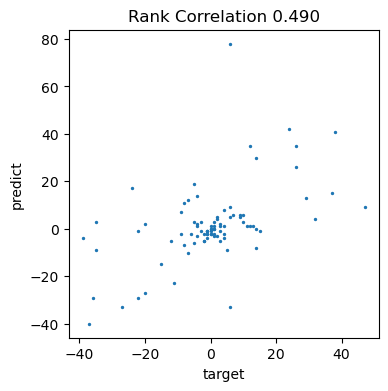

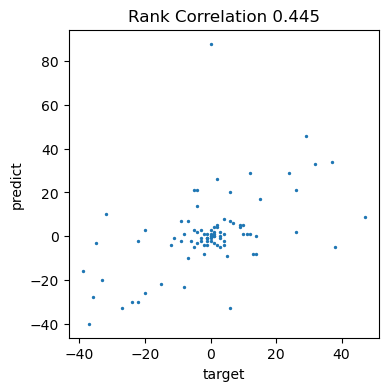

  0%|          | 3/10000 [00:05<4:46:56,  1.72s/it]

--------------------------------------------------------------------------------
            SOURCE: G8 G90 G9 G37 G26 G71 G81 G2 G6 G15 G84 G52 G11 G72 G19 G73 G78 G33 G22 G51 G97 G25 G30 G82 G1 G29 G100 G60 G91 G77 G36 G67 G66 G56 G55 G61 G4 G65 G62 G94 G57 G59 G44 G68 G58 G27 G70 G92 G24 G21 G3 G98 G83 G86 G74 G87 G64 G20 G96 G40 G28 G39 G85 G69 G16 G45 G54 G41 G32 G93 G50 G46 G48 G34 G18 G10 G80 G47 G53 G12 G95 G49 G89 G43 G75 G63 G99 G13 G23 G79 G17 G14 G5 G38 G35 G76 G88 G31 G42 G7
            TARGET: G8 G90 G15 G6 G9 G26 G37 G2 G81 G25 G19 G52 G78 G11 G73 G1 G72 G71 G29 G97 G30 G82 G60 G33 G84 G91 G61 G22 G3 G51 G4 G67 G77 G100 G36 G56 G66 G59 G65 G55 G94 G58 G68 G57 G27 G70 G44 G92 G63 G62 G21 G43 G13 G23 G87 G12 G83 G47 G31 G76 G89 G35 G85 G39 G93 G5 G50 G86 G88 G79 G48 G40 G28 G49 G34 G46 G41 G24 G32 G75 G54 G20 G80 G18 G7 G38 G95 G42 G14 G69 G16 G10 G74 G53 G64 G96 G17 G45 G98 G99
  PREDICTED GREEDY: G8 G90 G6 G81 G26 G37 G71 G9 G2 G52 G84 G19 G11 G73 G72 G29 G25 G78 G82 G97

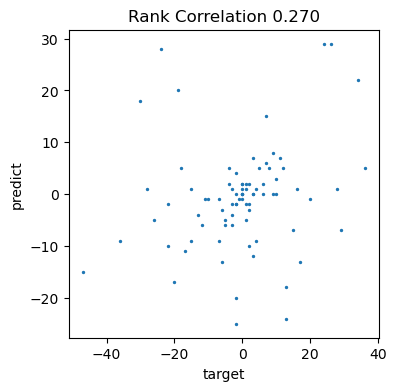

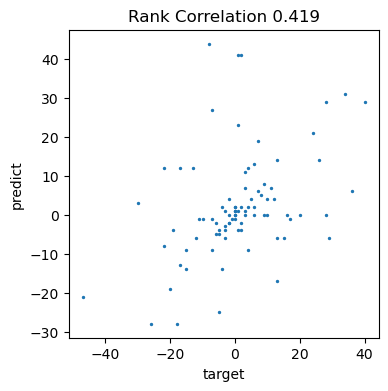

  0%|          | 4/10000 [00:06<4:46:15,  1.72s/it]

--------------------------------------------------------------------------------
            SOURCE: G22 G90 G6 G19 G37 G81 G71 G52 G84 G9 G2 G15 G29 G26 G73 G82 G11 G25 G78 G33 G72 G91 G30 G1 G51 G97 G36 G77 G60 G67 G100 G61 G66 G55 G56 G4 G62 G94 G65 G58 G57 G59 G68 G44 G64 G92 G70 G12 G27 G83 G69 G89 G21 G63 G34 G43 G39 G35 G3 G32 G13 G98 G23 G48 G41 G16 G80 G46 G99 G17 G38 G87 G50 G42 G86 G47 G79 G76 G18 G45 G85 G74 G75 G24 G7 G96 G31 G20 G88 G95 G93 G53 G14 G40 G54 G8 G5 G49 G10 G28
            TARGET: G22 G90 G81 G9 G37 G6 G26 G73 G72 G52 G71 G2 G19 G11 G84 G36 G15 G33 G55 G67 G97 G78 G29 G25 G60 G77 G51 G82 G61 G91 G1 G100 G30 G4 G56 G66 G62 G57 G65 G94 G68 G70 G44 G46 G53 G59 G34 G12 G18 G27 G58 G49 G17 G50 G92 G76 G14 G63 G85 G80 G3 G74 G47 G79 G69 G83 G16 G7 G5 G39 G88 G41 G21 G28 G95 G45 G98 G86 G24 G89 G64 G99 G20 G32 G87 G35 G13 G40 G75 G8 G42 G23 G54 G93 G31 G43 G10 G48 G96 G38
  PREDICTED GREEDY: G22 G90 G6 G81 G26 G37 G9 G71 G2 G52 G84 G19 G11 G73 G72 G29 G15 G25 G78 G9

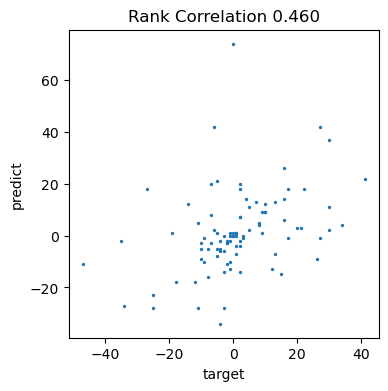

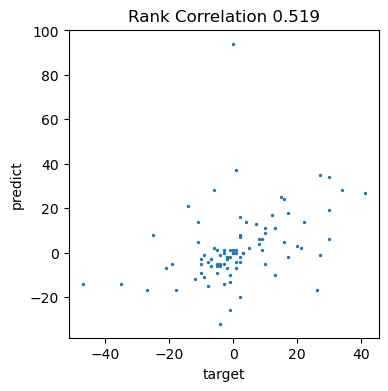

--------------------------------------------------------------------------------
            SOURCE: G7 G90 G81 G9 G26 G15 G73 G2 G6 G37 G82 G11 G71 G19 G52 G29 G4 G78 G60 G84 G33 G25 G72 G30 G97 G91 G66 G77 G36 G67 G100 G1 G56 G22 G51 G55 G61 G65 G59 G94 G58 G62 G57 G3 G27 G64 G68 G44 G70 G92 G89 G98 G83 G20 G21 G23 G99 G14 G63 G17 G43 G18 G88 G85 G12 G45 G53 G69 G24 G16 G42 G34 G87 G48 G5 G38 G39 G28 G75 G49 G50 G76 G80 G54 G32 G40 G47 G96 G13 G46 G79 G93 G86 G41 G10 G35 G8 G31 G95 G74
            TARGET: G7 G90 G71 G81 G26 G6 G11 G2 G73 G84 G52 G37 G29 G25 G97 G19 G78 G72 G15 G91 G82 G56 G1 G9 G22 G60 G30 G36 G33 G61 G66 G51 G67 G4 G55 G100 G77 G94 G65 G62 G59 G68 G58 G57 G70 G27 G76 G92 G44 G8 G21 G14 G49 G64 G87 G43 G12 G63 G41 G3 G98 G38 G10 G42 G95 G79 G34 G88 G53 G83 G93 G89 G54 G50 G74 G96 G13 G46 G31 G85 G20 G24 G40 G69 G47 G23 G32 G28 G86 G5 G75 G18 G80 G17 G35 G45 G16 G99 G39 G48
  PREDICTED GREEDY: G7 G90 G6 G81 G26 G37 G9 G71 G2 G52 G84 G19 G11 G73 G72 G29 G25 G78 G15 G82

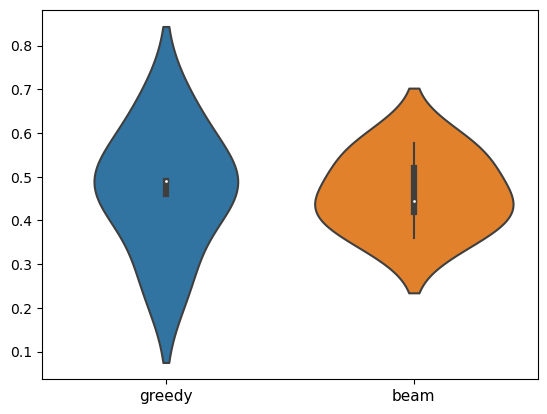

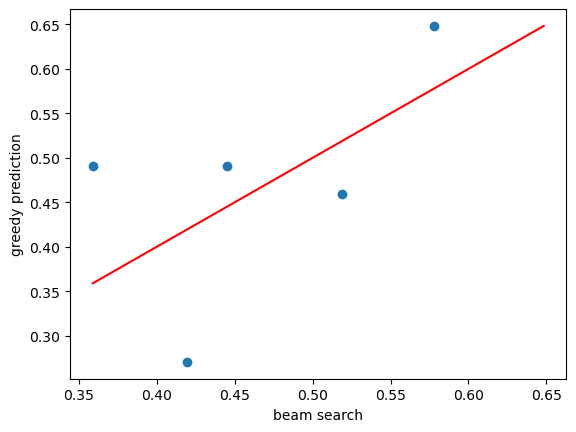

  0%|          | 4/10000 [00:08<6:04:38,  2.19s/it]


In [6]:
plot=True
print_text=True
run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, print_msg=print, num_examples=5, plot=plot, print_text=print_text)